# K-space Sampling Validation

Run `make kspace-data` (or `make all`) from `python/validation` to refresh the JSON artifacts under `python/validation/artifacts/kspace_data/`. This notebook visualizes the preset Γ–X–M–Γ and Γ–M–K–Γ paths, a custom k-mesh, and a bespoke path by overlaying them on a 3x3 reciprocal lattice grid.

In [1]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path.cwd()
KSPACE_DIR = NOTEBOOK_DIR / 'artifacts' / 'kspace_data'
print(f'Reading k-space reports from {KSPACE_DIR}')

def load_report(name: str) -> dict:
    path = KSPACE_DIR / name
    if not path.exists():
        raise FileNotFoundError(f'Missing artifact: {path}')
    with path.open(encoding='utf-8') as handle:
        payload = json.load(handle)
    payload['artifact_path'] = path
    return payload

REPORTS = {
    'square_path': load_report('kspace_square_path.json'),
    'triangular_path': load_report('kspace_triangular_path.json'),
    'custom_mesh': load_report('kspace_custom_mesh.json'),
    'custom_path': load_report('kspace_custom_path.json'),
}

Reading k-space reports from /home/renlephy/mpb-gpu-2D/python/validation/artifacts/kspace_data


In [2]:
def _reciprocal_array(report):
    return np.array([entry['cartesian'] for entry in report['reciprocal_grid']], dtype=float)

def _point_array(report):
    return np.array([entry['cartesian'] for entry in report['points']], dtype=float)

def plot_reciprocal_background(ax, report):
    grid = _reciprocal_array(report)
    ax.scatter(grid[:, 0], grid[:, 1], s=35, color='#bbbbbb', label='Reciprocal grid', zorder=1)
    gamma = next((entry['cartesian'] for entry in report['reciprocal_grid'] if entry['indices'] == [0, 0]), None)
    if gamma is not None:
        ax.scatter([gamma[0]], [gamma[1]], color='black', s=60, zorder=3)
        ax.annotate('Γ', (gamma[0], gamma[1]), textcoords='offset points', xytext=(6, 4))

def configure_axes(ax):
    ax.set_aspect('equal')
    ax.axhline(0, color='#dddddd', linewidth=0.6, zorder=0)
    ax.axvline(0, color='#dddddd', linewidth=0.6, zorder=0)
    ax.set_xlabel('$k_x$ (1/a)')
    ax.set_ylabel('$k_y$ (1/a)')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)

def plot_kpath(report, title, color='#1f77b4'):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_reciprocal_background(ax, report)
    coords = _point_array(report)
    ax.plot(coords[:, 0], coords[:, 1], color=color, linewidth=1.2, marker='o', markersize=3, label='k-path', zorder=2)
    start = coords[0]
    ax.scatter([start[0]], [start[1]], color=color, s=65, zorder=4)
    meta = report.get('path') or {}
    total = meta.get('total_length', 0.0)
    segs = meta.get('segments_per_leg')
    subtitle = f'L = {total:.2f}' if segs is None else f'L = {total:.2f} | segments/leg = {segs}'
    ax.set_title(f'{title}\n{subtitle}')
    configure_axes(ax)
    ax.legend(loc='best', frameon=False)
    plt.show()

def plot_kmesh(report, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_reciprocal_background(ax, report)
    coords = _point_array(report)
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=coords[:, 1], cmap='magma', s=35, label='k-mesh', zorder=2)
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('$k_y$ (1/a)')
    meta = report.get('mesh') or {}
    shape = meta.get('shape', ['?', '?'])
    ax.set_title(f"{title}\nshape = {shape[0]}x{shape[1]}, extent = {meta.get('extent', 0.0):.2f}")
    configure_axes(ax)
    ax.legend(loc='best', frameon=False)
    plt.show()

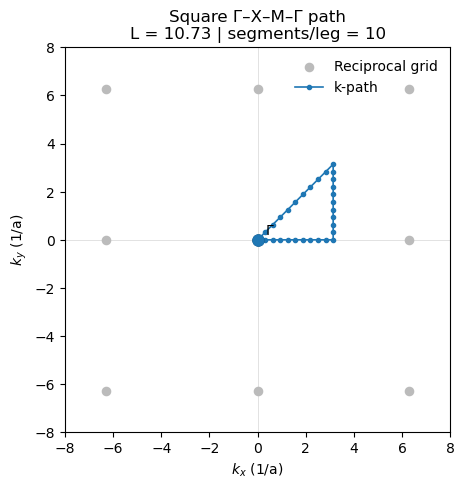

In [3]:
plot_kpath(REPORTS['square_path'], 'Square Γ–X–M–Γ path')

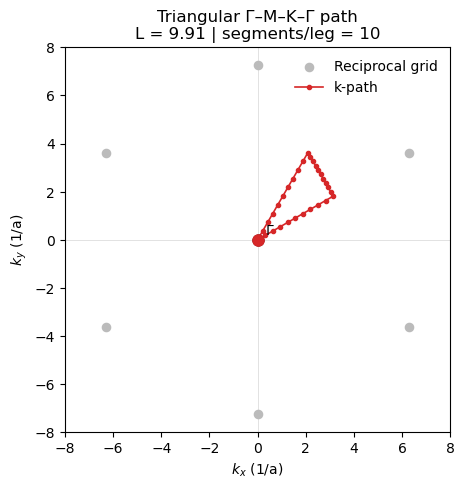

In [4]:
plot_kpath(REPORTS['triangular_path'], 'Triangular Γ–M–K–Γ path', color='#d62728')

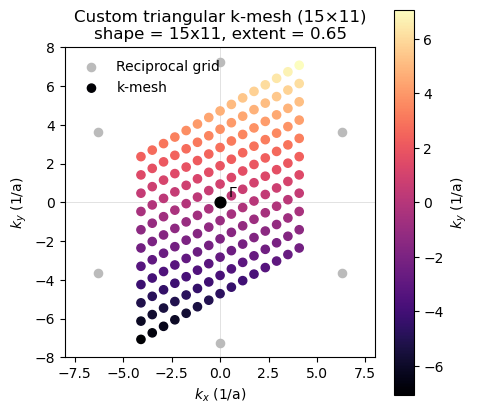

In [5]:
plot_kmesh(REPORTS['custom_mesh'], 'Custom triangular k-mesh (15×11)')

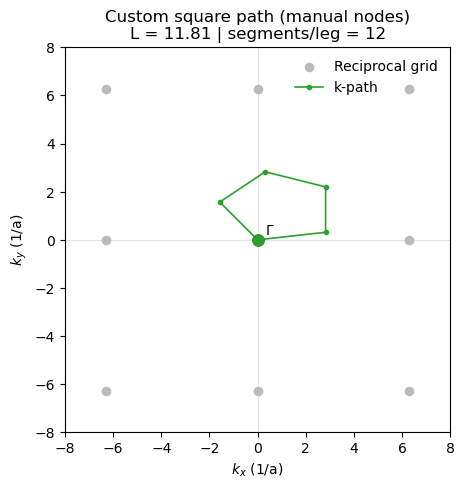

In [6]:
plot_kpath(REPORTS['custom_path'], 'Custom square path (manual nodes)', color='#2ca02c')